# Conveyor Belt Thermodynamic Integration with Ensembler
In this notebook, we give examples how to run conveyor belt simulations with Ensembler. 

Maintainers: [@SchroederB](https://https://github.com/SchroederB), [@linkerst](https://https://github.com/linkerst), [@dfhahn](https://https://github.com/dfhahn)

## Loading Ensembler and necessary external packages 

In [2]:
import os, sys
sys.path.append(os.getcwd()+"/..")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from mpl_toolkits.mplot3d import Axes3D

import ensembler.potentials.OneD as pot
import ensembler.system.perturbed_system as system
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.samplers import stochastic

## Interactive Example

In [3]:
from ensembler.visualisation.interactive_plots import interactive_conveyor_belt

iwidget = interactive_conveyor_belt(nbins=10, numsys=3, steps=10)

## Build a conveyor belt object
For building a `conveyorBelt` object, you first have to build a `system`, which will be used as a template for the replicas. The `system` itself needs to to be initialized with a potential and an integrator. For details, see the Tutorial Simulations.

In [8]:
sampler = stochastic.metropolisMonteCarloIntegrator()
potential = pot.linearCoupledPotentials()
sys = system.perturbedSystem(potential=potential , 
                              sampler=sampler)

Additional the number of replicas `n_replicas` and the initial capital Lambda value needs to be specified. The latter can usually be set to 0. An additional (optional) argument is the `build` variable, which will be discussed later.

The output shows the current state of the conveyor belt as a table with the replica ID, the corresponding lambda value and the energy of the replica.

In [10]:
ensemble = cvb.conveyorBelt(capital_lambda=0.0,
                n_replicas=8,
                system=sys)
ensemble

0.0      0.00    11.757
1.0      0.25    38.266
2.0      0.50    66.084
3.0      0.75    92.909
4.0      1.00   121.812
5.0      0.75    92.836
6.0      0.50    75.666
7.0      0.25    38.822

## Start a conveyor belt simulation 
The conveyor belt is simulated by using its member function `simulate` with the number of steps as argument. 

In [12]:
steps = 10
ensemble.simulate(steps)

The trajectories of the ensemble `cvb_traj` and the single systems `sys_trajs` can be retrieved by using its member function `get_trajs`.

In [13]:
(cvb_traj, systrajs) = ensemble.get_trajs()

The ensemble trajectory is a `pandas.DataFrame` object with the following columns:
- **Step**: index of frame (starting from 1)
- **capital_lambda**: the capital lambda of the frame
- **TotE**: the current total energy of the ensemble
- **biasE**: the current bias energy
- **doAccept**: information whether the Monte Carlo step before the frame was accepted or not

In [9]:
cvb_traj.head()

,Step,capital_lambda,TotE,biasE,doAccept
0,1,5.547756,24.870174,24.870174,True
1,2,5.265416,2.282267,2.282267,True
2,3,5.265416,8.705540,0.000000,False
3,4,5.100920,8.884372,8.884372,True
4,5,5.100920,22.111975,0.000000,False


The system trajectory object `systrajs` is a `list` of `pandas.DataFrame` objects (one per replica) with the following columns:
- **position**: (spatial) position of particle
- **temperature**: temperature
- **total_system_energy**: the current total energy of the replica
- **total_potential_energy**: the current potential energy of the replica
- **total_kinetic_energy**: the current kinetic energy of the replica
- **dhdpos**: the derivative of the hamiltonian with repect to the position (negative of the force)
- **velocity**: velocity of the particle
- **lam**: lambda value of the partical
- **dhdlam**: Hamiltonian derivative with respect to lambda
The kinetic energy and the velocity are `NaN` in the following, becauce this example uses the stochastic `metropolisMonteCarloIntegrator`, which does not calculate velocities.

In [8]:
systrajs[0].head()

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity,lam,dhdlam
0,2.93513,300.0,25.844939,25.844939,NaN,17.6108,NaN,0.000000,43.074899
1,-0.5471531451097928,300.0,0.149688,0.149688,NaN,-3.4822817132716772,NaN,0.000000,1.496883
2,-0.8714768137003843,300.0,0.379736,0.379736,NaN,-0.3243236685905915,NaN,0.000000,3.797359
3,-1.5265719564600495,300.0,3.892903,3.892903,NaN,-0.6550951427596652,NaN,0.234094,11.652110
4,0.08557630108654513,300.0,0.012233,0.012233,NaN,1.6121482575465946,NaN,0.234094,0.036617


## Visualizations of the trajectories

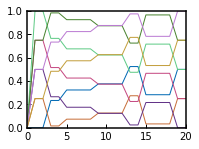

In [10]:
for i in systrajs:
    plt.plot(systrajs[i].index, systrajs[i].lam)

In [11]:
nbins=100
bins=np.zeros(nbins)
dhdlbins=np.zeros(nbins)
for i in systrajs:
    for j in range(systrajs[i].shape[0]):
        index=int(np.floor(systrajs[i].lam[j]*nbins))
        print(index)
        if index == nbins:
            index=nbins-1
        bins[index]+=1
        dhdlbins[index]+=systrajs[i].dhdlam[j]
dhdlbins/=bins
#dhdlbins

0
0
0
23
23
32
32
32
32
37
37
37
37
52
52
28
28
28
28
50
50
0
25
25
1
1
7
7
7
7
12
12
12
12
27
27
3
3
3
3
25
25
0
50
50
26
26
17
17
17
17
12
12
12
12
2
2
21
21
21
21
0
0
0
75
75
51
51
42
42
42
42
37
37
37
37
22
22
46
46
46
46
24
24
0
100
100
76
76
67
67
67
67
62
62
62
62
47
47
71
71
71
71
49
49
0
75
75
98
98
92
92
92
92
87
87
87
87
72
72
96
96
96
96
74
74
0
50
50
73
73
82
82
82
82
87
87
87
87
97
97
78
78
78
78
99
99
0
25
25
48
48
57
57
57
57
62
62
62
62
77
77
53
53
53
53
75
75


/opt/anaconda3/envs/ensembler/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Integral =  nan


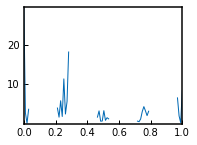

In [12]:
plt.plot(np.linspace(0,1,nbins), dhdlbins)
integral=np.sum(dhdlbins)*1.0/nbins
print('Integral = ', integral)

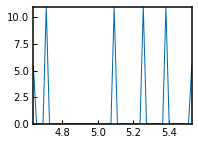

In [13]:
h1=np.histogram(cvb_traj.capital_lambda, bins=50, density=1)
plt.plot(h1[1][:-1], h1[0])
#plt.ylim(0.14, 0.185)

Text(0, 0.5, '$\\lambda$')

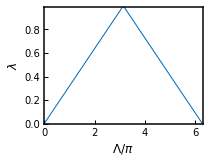

In [14]:
caplam = np.linspace(0, 2*np.pi, 100)
x=[]
for i in caplam:
    x.append(ensemble.calculate_replica_lambda(i, 0))
plt.plot(caplam, x)
plt.xlabel('$\Lambda / \pi$')
plt.ylabel('$\lambda$')

In [15]:
#analytical
u=1.66053886e-27
NA=6.0221415e23
hbar=1.054571800e-34*1e12*1e-3*NA  #kJ/mol*ps
R=0.00831446 #kJ/mol/K
mu=0.5  #u
T=300.0  #K
fc1=1  #kJ/nm^2/mol
fc2=11.0 #kJ/nm^2/mol
omega1=np.sqrt(fc1/mu)
omega2=np.sqrt(fc2/mu)
print('Omega', omega1, omega2)
alpha1=hbar*np.sqrt(fc1/mu)/(R*T)
alpha2=hbar*np.sqrt(fc2/mu)/(R*T)
print(alpha1, alpha2)
Z1=np.exp(-alpha1/2.0)/(1-np.exp(-alpha1))
Z2=np.exp(-alpha2/2.0)/(1-np.exp(-alpha2))
F1=-R*T*np.log(Z1)
F2=-R*T*np.log(Z2)
DF=F2-F1
DF2=-R*T*np.log(Z2/Z1)
print(DF, DF2, F1, F2)

Omega 1.4142135623730951 4.69041575982343
0.03600698886161772 0.11942167188449208
2.991927940369414 2.991927940369415 -8.291150088634001 -5.299222148264588


## Conveyor Belt Animation

IndexError: index 1 is out of bounds for axis 0 with size 1

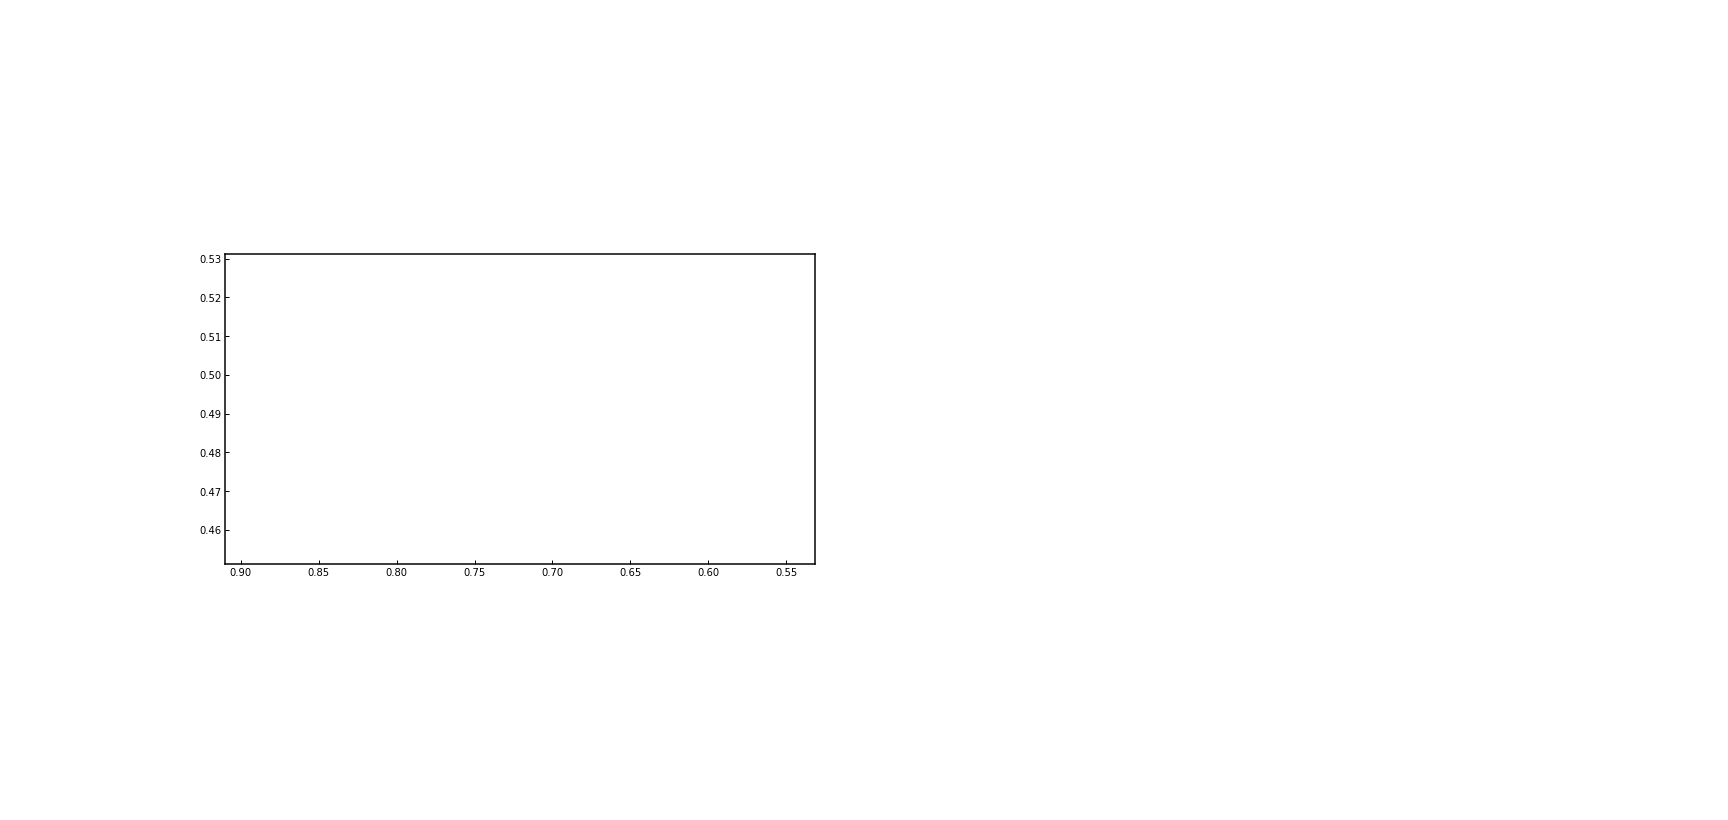

In [16]:
import ensembler.visualisation.plotConveyorBelt as plotEnsembler
nbins=2
dhdlbins=2
lam = np.linspace(0, 1, nbins)
ene = np.cumsum(dhdlbins)/nbins

fig = plotEnsembler.plotEnsembler(lam, ene, CapLam=0.2, M=8)